This notebook contains three parts:
1. Finding outliers to subsample train dataset by. We do this visually by plotting box or barplots.
2. Checking train and validation RMSE after training on subsample with full sample
3. Pick subsample predictions for New/Unseen cases. Samples out of subsample reverts to original predictions

In [1]:
import pandas as pd
import numpy as np
import os, re
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from collections import Counter
from datetime import datetime

from sklearn.metrics import mean_squared_error
%matplotlib inline

### 1. Finding and Visualising Outliers

In [49]:
dummy_list = []
bools = []
numerics = []
strings = []

def plot_lineplot(df, i, rotation=None, width=6, height=3.5, save=False, convert=False):
    if convert:
        df[i] = df[i].applymap(lambda x: re.sub('[^0-9]', '', x))
    x = df[i].dropna()
    nums = dict(Counter(x))
    nums_df = pd.DataFrame({
        i: list(nums.keys()),
        'count': list(nums.values())
    })
    sns.set(rc={'figure.figsize':(width, height)})
    ax = sns.lineplot(data=nums_df, x=i, y='count')
    ax.set_title(f'Lineplot of {i}')
    if rotation is not None:
        plt.xticks(rotation=rotation)
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_numeric(df, i, save=False):
    x = df[i]
    sns.set(rc={'figure.figsize':(6,1)})
    ax = sns.boxplot(x, color='lightblue')
    ax.set_title(f'Boxplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_boxplot', bbox_inches = "tight")
    plt.show()
    
def plot_categorical(df, i, top_k=None, save=False):
    x = df[i]
    total = float(len(x))
    if top_k is None:
        n_cates = len(set(x))
    else:
        n_cates=top_k
    sns.set(rc={'figure.figsize':(6, n_cates/8+2)})
    sns.set(font="SimSun")
    ax = sns.countplot(y=x, color="lightblue", dodge=False, order = x.value_counts().iloc[:n_cates].index)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%\n'
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='right', va='center')
    ax.set_title(f'Countplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_countplot', bbox_inches = "tight")
    plt.show()
        
def plot_dates(df, i, save=False):
    x = df[i].dropna().apply(lambda d: datetime.strptime(d, dates_dict[i]))
    dates = dict(Counter(x))
    dates_df = pd.DataFrame({
        'date': list(dates.keys()),
        'count': list(dates.values())
    })
    sns.set(rc={'figure.figsize':(6,3.5)})
    ax = sns.lineplot(data=dates_df, x='date', y='count')
    ax.set_title(f'Lineplot of {i}')
    plt.tight_layout()
    if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
    plt.show()
    
def plot_all(df, top_k=None, save=False, num_string_pattern = '\d{4}\-\d{2}'):
    for i in df.columns:
        _df = df.dropna(subset=[i])
        if len(df)!=len(_df):
            print(f'Plot for "{i}" (Missing {len(df)-len(_df)} items...)')
        else:
            print(f'Plot for "{i}"')
        if is_numeric_dtype(df[i]):
            if len(set(_df))==2:
                bools.append(i, save=save)
                plot_categorical(_df, i, top_k=top_k, save=save)
            else:
                numerics.append(i)
                plot_numeric(_df, i, save=save)
                if i in dummy_list:
                    plot_categorical(_df, i, top_k=top_k, save=save)
        else:
            if i in dates_dict.keys():
                plot_dates(_df, i, save=save)
            elif all([bool(re.match(num_string_pattern, s)) for s in _df[i]]):
                # this matches Year-Month format of YYYY-MM (can custom pattern, or by |)
                plot_lineplot(_df, i, rotation=90, height=3.5, width=len(df[i].unique())/7.2, save=save)
            else:
                strings.append(i)
                plot_categorical(_df, i, save=save)
    
    print(f'----- auto eda summary -----')
    print(f'identified bools: {bools}')
    print(f'identified numerics: {numerics}')
    print(f'identified strings: {strings}')
    print(f'cols to fix: {list(train_df.columns.difference(bools+numerics+strings))}')
           
# plot_all(train_df, save=False)

In [4]:
train_df = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\train_df_fe_all.csv")
train_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,annual_TURC,annual_RURC,annual_TP,annual_AMHIFWPHMECC,quarterly_GICD,quarterly_ULCOOE,quarterly_HPI,monthly_PLR,monthly_SDR,monthly_CPI
0,2001-08,pasir ris,4 room,2,pasir ris drive 4,01 to 06,118.0,model a,uncategorized,1989,...,2.7,3.8,4138012.0,1925.0,47195.8,93.0,70.6,5.80,1.28,75.299
1,2014-10,punggol,5 room,0,punggol field,10 to 15,110.0,improved,uncategorized,2003,...,2.6,3.7,5469724.0,3418.0,105970.4,101.5,137.0,5.35,0.11,99.255
2,2020-09,sengkang,5 room,2,fernvale lane,01 to 06,112.0,premium apartment,uncategorized,2004,...,3.8,5.2,5685807.0,4022.0,113497.3,88.2,133.9,5.25,0.10,100.139
3,2000-10,clementi,3 room,0,clementi avenue 4,06 to 10,67.0,new generation,uncategorized,1980,...,4.4,6.0,4027887.0,1735.0,50041.6,99.2,75.8,5.80,1.28,74.844
4,2013-01,bukit batok,3 room,0,bukit batok street 11,06 to 10,73.0,model a,uncategorized,1985,...,2.6,3.9,5399162.0,3204.0,95412.4,101.0,148.6,5.38,0.11,98.121


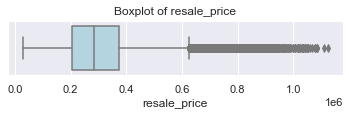

In [6]:
plot_numeric(train_df, 'resale_price', save=False)

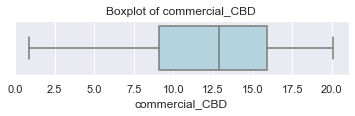

In [37]:
plot_numeric(train_df, 'commercial_CBD', save=False)

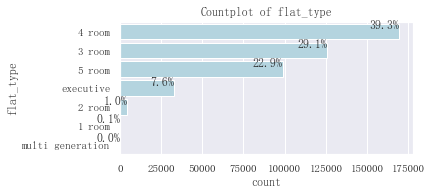

In [39]:
plot_categorical(train_df, 'flat_type', save=False)

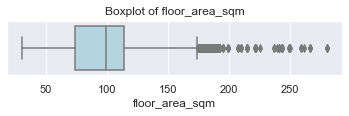

In [7]:
plot_numeric(train_df, 'floor_area_sqm', save=False)

In [41]:
df = train_df.copy()
cols = ['floor_area_sqm']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df = df[df['flat_type'].isin(['4 room', '5 room', '3 room', 'executive', '2 room'])]

df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,annual_TURC,annual_RURC,annual_TP,annual_AMHIFWPHMECC,quarterly_GICD,quarterly_ULCOOE,quarterly_HPI,monthly_PLR,monthly_SDR,monthly_CPI
0,2001-08,pasir ris,4 room,2,pasir ris drive 4,01 to 06,118.0,model a,uncategorized,1989,...,2.7,3.8,4138012.0,1925.0,47195.8,93.0,70.6,5.80,1.28,75.299
1,2014-10,punggol,5 room,0,punggol field,10 to 15,110.0,improved,uncategorized,2003,...,2.6,3.7,5469724.0,3418.0,105970.4,101.5,137.0,5.35,0.11,99.255
2,2020-09,sengkang,5 room,2,fernvale lane,01 to 06,112.0,premium apartment,uncategorized,2004,...,3.8,5.2,5685807.0,4022.0,113497.3,88.2,133.9,5.25,0.10,100.139
3,2000-10,clementi,3 room,0,clementi avenue 4,06 to 10,67.0,new generation,uncategorized,1980,...,4.4,6.0,4027887.0,1735.0,50041.6,99.2,75.8,5.80,1.28,74.844
4,2013-01,bukit batok,3 room,0,bukit batok street 11,06 to 10,73.0,model a,uncategorized,1985,...,2.6,3.9,5399162.0,3204.0,95412.4,101.0,148.6,5.38,0.11,98.121


In [42]:
len(df)

430096

In [43]:
len(train_df)

431732

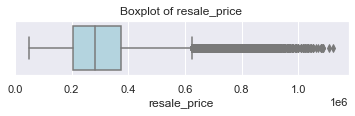

In [44]:
plot_numeric(df, 'resale_price', save=False)

Plot for "month"


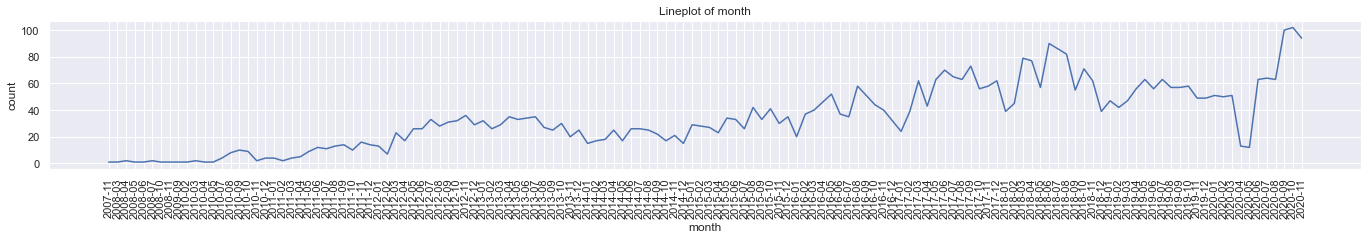

Plot for "town"


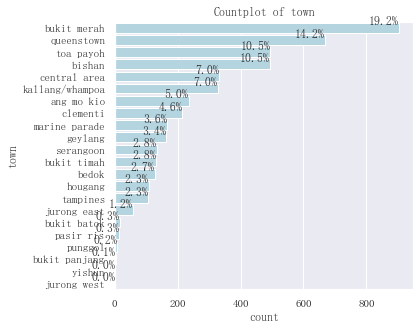

Plot for "flat_type"


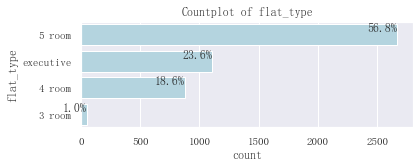

Plot for "block"


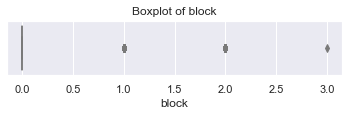

Plot for "street_name"


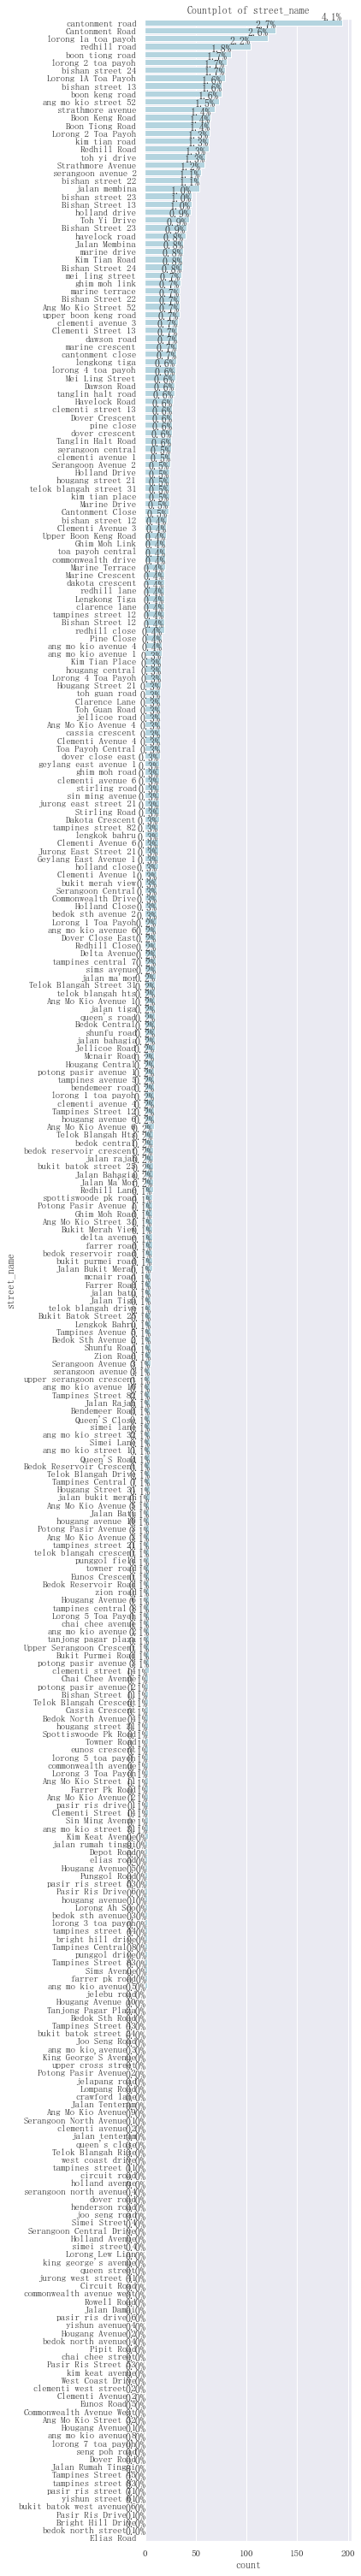

Plot for "storey_range"


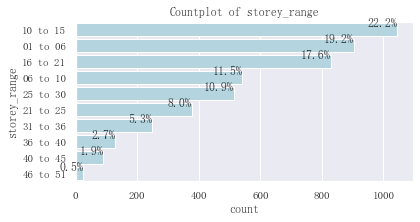

Plot for "floor_area_sqm"


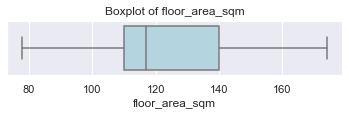

Plot for "flat_model"


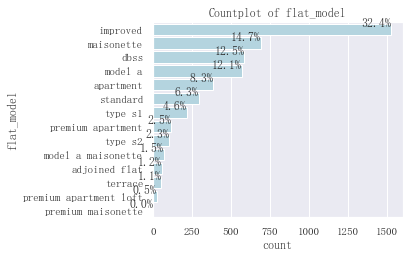

Plot for "eco_category"


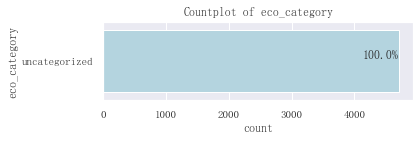

Plot for "lease_commence_date"


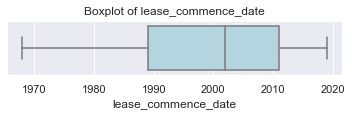

Plot for "latitude"


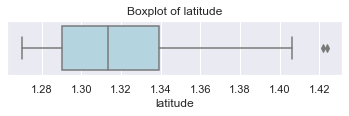

Plot for "longitude"


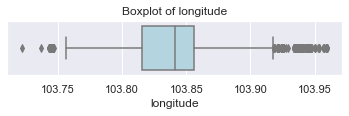

Plot for "elevation"


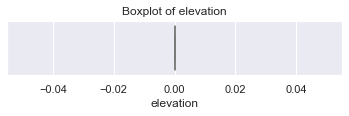

Plot for "subzone"


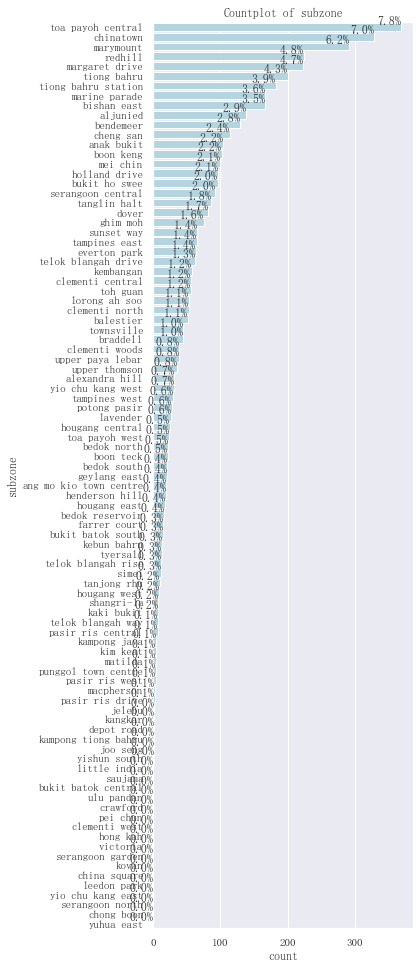

Plot for "planning_area"


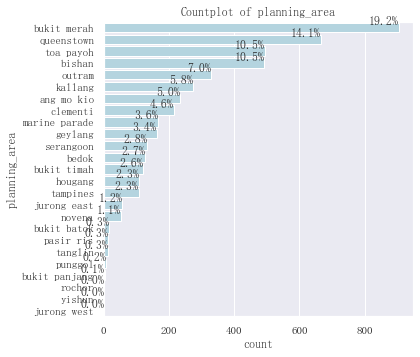

Plot for "region"


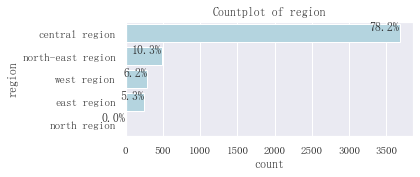

Plot for "resale_price"


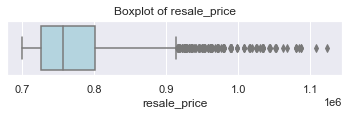

Plot for "resale_year"


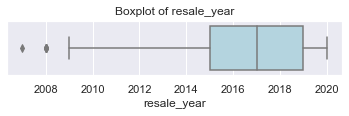

Plot for "resale_month"


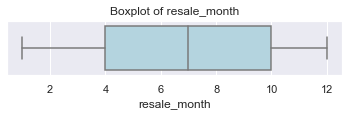

Plot for "resale_quarter"


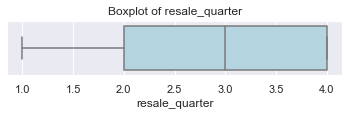

Plot for "flat_age"


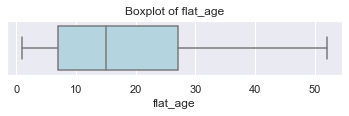

Plot for "resale_price_sqm"


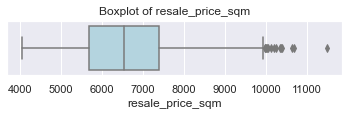

Plot for "commercial_CBD"


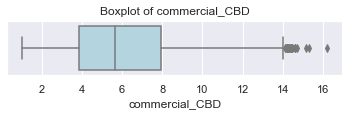

Plot for "commercial_type_CR"


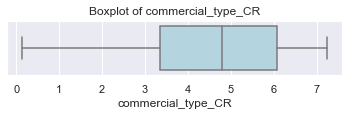

Plot for "commercial_type_IEBP"


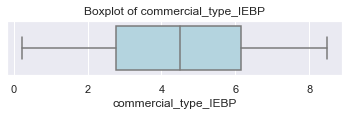

Plot for "commercial_type_IEPB"


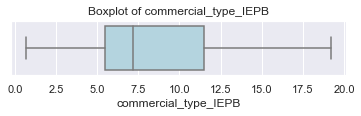

Plot for "commercial_type_BN"


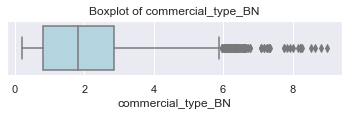

Plot for "commercial_type_IHL"


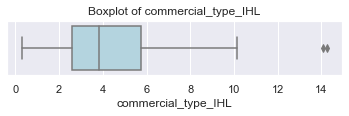

Plot for "hawker_ECLFV"


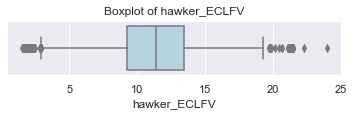

Plot for "hawker_NFC"


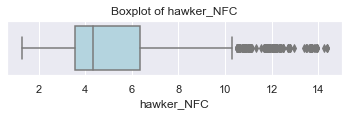

Plot for "hawker_CRB89"


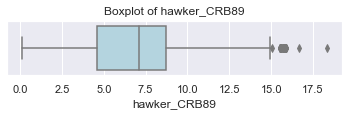

Plot for "hawker_OARB51OARFCSM"


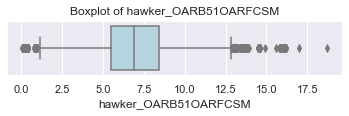

Plot for "hawker_CRB"


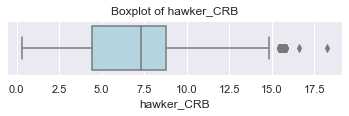

Plot for "hawker_HVMFC"


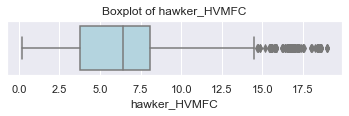

Plot for "hawker_BFC"


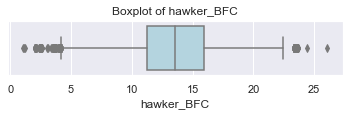

Plot for "hawker_CCFC"


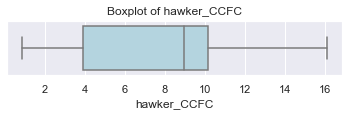

Plot for "hawker_TBM"


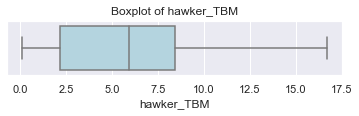

Plot for "hawker_BPHC"


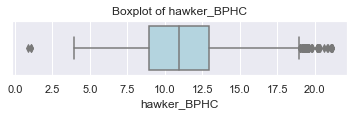

Plot for "hawker_GMFC"


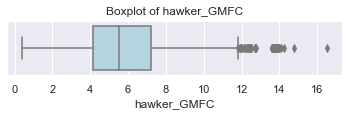

Plot for "hawker_YPHC"


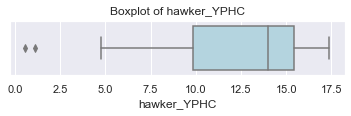

Plot for "hawker_OTH"


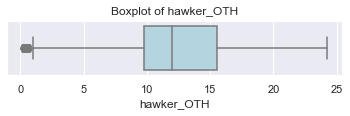

Plot for "hawker_KAHC"


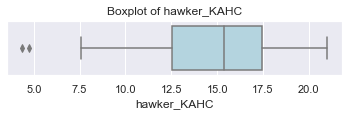

Plot for "hawker__"


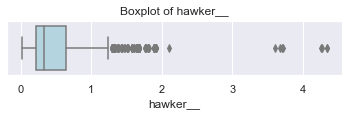

Plot for "hawker_highrating_"


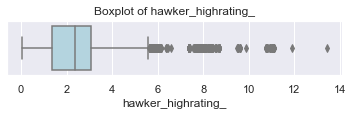

Plot for "hawker_established_"


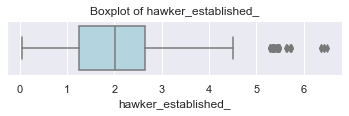

Plot for "prisch_top50_"


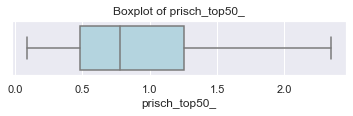

Plot for "prisch_top50_<=1km"


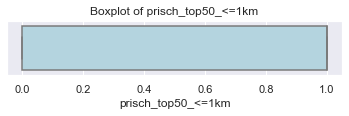

Plot for "prisch_top50_1to2km"


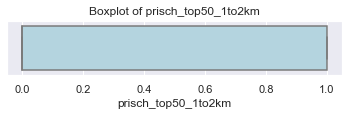

Plot for "prisch_top50_2to4km"


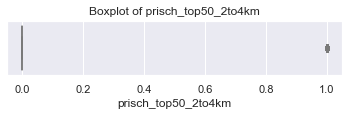

Plot for "malls_GWC"


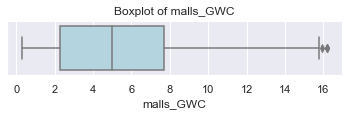

Plot for "malls_IO"


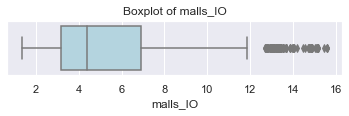

Plot for "malls_TSMBS"


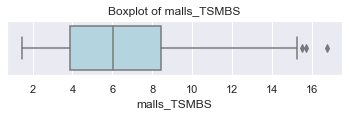

Plot for "malls_NAC"


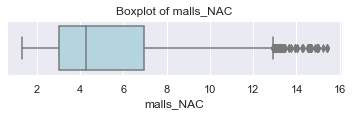

Plot for "malls_PS"


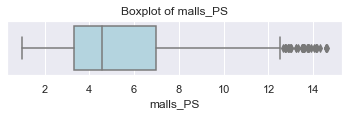

Plot for "malls_SC"


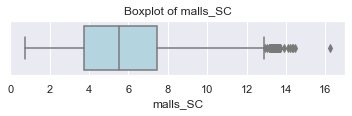

Plot for "malls_OTH"


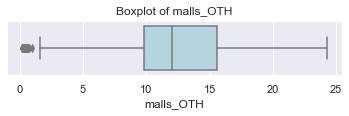

Plot for "malls_CA"


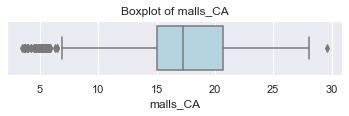

Plot for "malls_JCA"


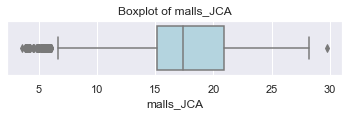

Plot for "malls_VivoCity"


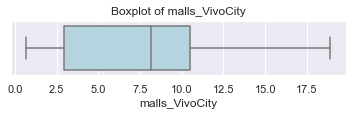

Plot for "malls_JP"


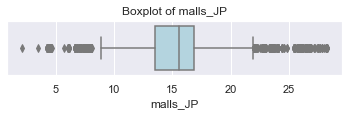

Plot for "malls__"


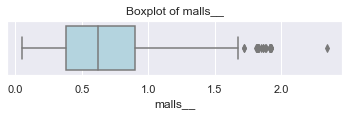

Plot for "malls_ratingsbin_4.1"


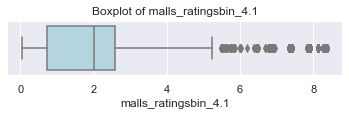

Plot for "malls_ratingsbin_4.3"


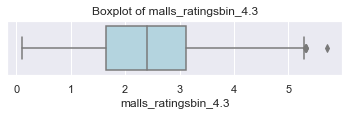

Plot for "malls_ratingsbin_>4.0"


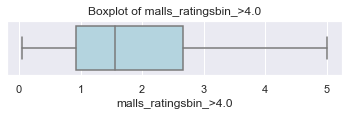

Plot for "malls_ratingsbin_4.2"


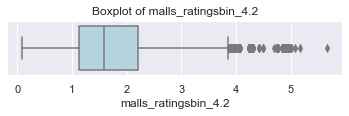

Plot for "malls_ratingsbin_4.0"


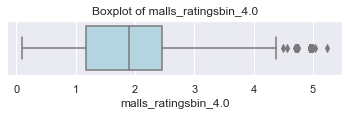

Plot for "malls_ratingsbin_>=4.5"


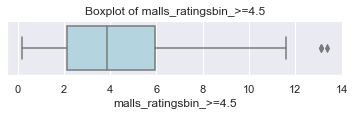

Plot for "malls_ratingsbin_4.4"


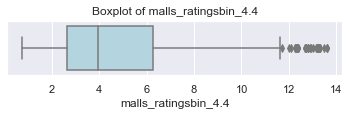

Plot for "malls_established_"


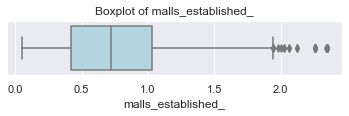

Plot for "station_type_mrt"


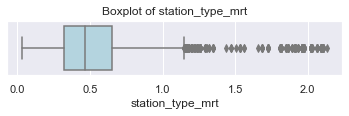

Plot for "station_type_other"


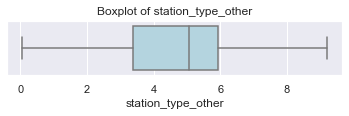

Plot for "station_interchange_"


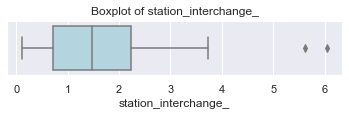

Plot for "station_EW_"


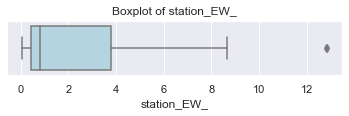

Plot for "station_NS_"


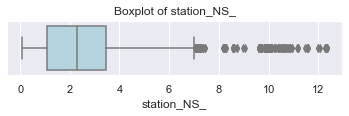

Plot for "station_NE_"


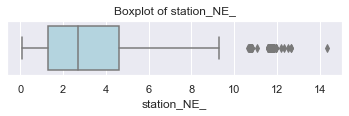

Plot for "station_CC_"


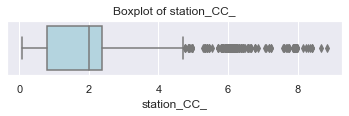

Plot for "station_DT_"


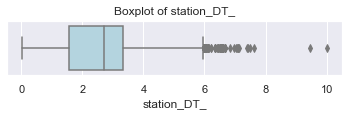

Plot for "demographics_elderly"


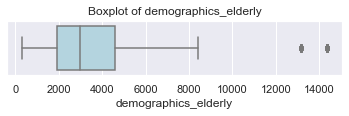

Plot for "demographics_kids"


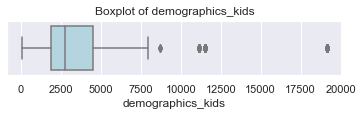

Plot for "demographics_middle"


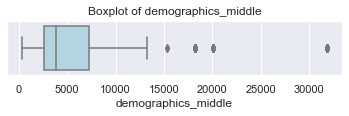

Plot for "demographics_older"


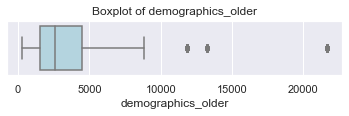

Plot for "demographics_youngads"


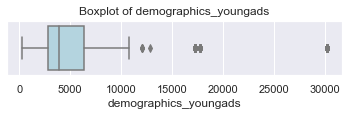

Plot for "demographics_youth"


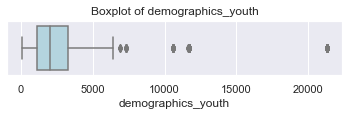

Plot for "annual_TLF"


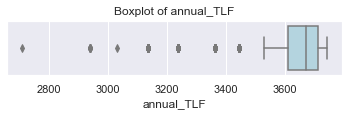

Plot for "annual_TEP"


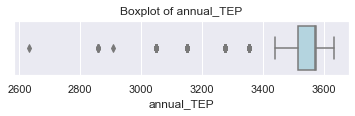

Plot for "annual_TUP"


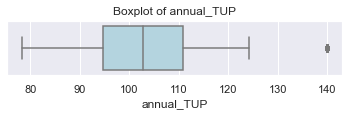

Plot for "annual_TURC"


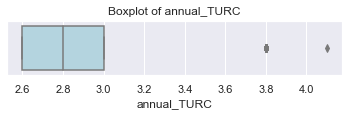

Plot for "annual_RURC"


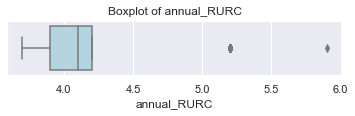

Plot for "annual_TP"


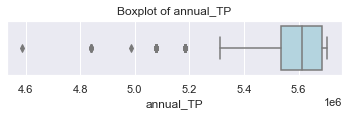

Plot for "annual_AMHIFWPHMECC"


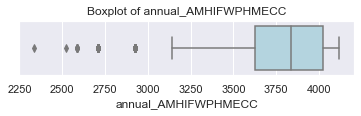

Plot for "quarterly_GICD"


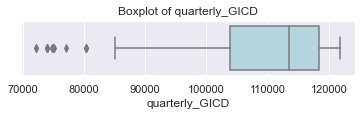

Plot for "quarterly_ULCOOE"


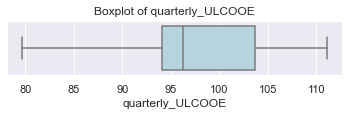

Plot for "quarterly_HPI"


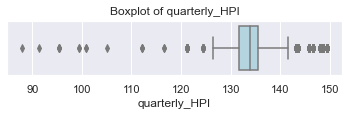

Plot for "monthly_PLR"


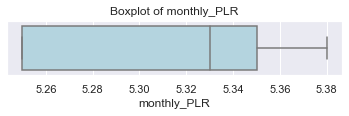

Plot for "monthly_SDR"


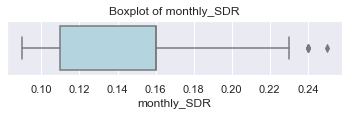

Plot for "monthly_CPI"


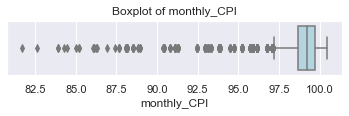

----- auto eda summary -----
identified bools: []
identified numerics: ['block', 'floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'resale_price', 'resale_year', 'resale_month', 'resale_quarter', 'flat_age', 'resale_price_sqm', 'commercial_CBD', 'commercial_type_CR', 'commercial_type_IEBP', 'commercial_type_IEPB', 'commercial_type_BN', 'commercial_type_IHL', 'hawker_ECLFV', 'hawker_NFC', 'hawker_CRB89', 'hawker_OARB51OARFCSM', 'hawker_CRB', 'hawker_HVMFC', 'hawker_BFC', 'hawker_CCFC', 'hawker_TBM', 'hawker_BPHC', 'hawker_GMFC', 'hawker_YPHC', 'hawker_OTH', 'hawker_KAHC', 'hawker__', 'hawker_highrating_', 'hawker_established_', 'prisch_top50_', 'prisch_top50_<=1km', 'prisch_top50_1to2km', 'prisch_top50_2to4km', 'malls_GWC', 'malls_IO', 'malls_TSMBS', 'malls_NAC', 'malls_PS', 'malls_SC', 'malls_OTH', 'malls_CA', 'malls_JCA', 'malls_VivoCity', 'malls_JP', 'malls__', 'malls_ratingsbin_4.1', 'malls_ratingsbin_4.3', 'malls_ratingsbin_>4.0', 'malls_ratingsbin_4.2'

In [50]:
# expensive houses
plot_all(df[df['resale_price']>700000], save=False)

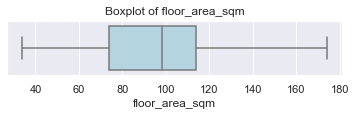

In [45]:
plot_numeric(df, 'floor_area_sqm', save=False)

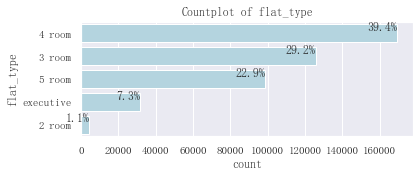

In [47]:
plot_categorical(df, 'flat_type', save=False)

### 2. Review predictions on Train
we subsampled train dataset by 'floor_area_sqm' and 'flat_type', we want to review the accuracy between original and subsampled model on this subsample set.

In [43]:
orig_pred_train = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\pred_train.csv")
orig_pred_test = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\pred_test.csv")
orig_pred = pd.concat([orig_pred_train, orig_pred_test], axis=0)
orig_pred = orig_pred.sort_values(by='index')

orig_pred

,index,pred
90311,0,239608.817606
273853,1,427444.972144
96433,2,366287.380222
190472,3,148183.791614
2614,4,313251.785500
...,...,...
204863,431727,217306.475465
18849,431728,390047.636874
19131,431729,253395.786465
16464,431730,508211.046929


In [44]:
train_df = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\train_df_fe_all.csv")
sub_pred_train = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_WithoutOutliers\pred_train.csv")
sub_pred_test = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_WithoutOutliers\pred_test.csv")
sub_pred = pd.concat([sub_pred_train, sub_pred_test], axis=0)
sub_pred = sub_pred.sort_values(by='index')

sub_pred

,index,pred
89319,0,235612.626712
272838,1,426639.074795
95381,2,364702.033056
189772,3,148689.038941
1592,4,309006.012271
...,...,...
23980,431727,219105.393981
98064,431728,389700.168356
12121,431729,254709.769565
45929,431730,509563.761907


In [45]:
sub_ixes = list(sub_pred['index'])
print(min(train_df.loc[sub_ixes]['floor_area_sqm']))
print(max(train_df.loc[sub_ixes]['floor_area_sqm']))
print(train_df.loc[sub_ixes]['flat_type'].unique())

34.0
174.0
['4 room' '5 room' '3 room' 'executive' '2 room']


In [46]:
orig_pred[orig_pred['index'].isin(sub_ixes)]

,index,pred
90311,0,239608.817606
273853,1,427444.972144
96433,2,366287.380222
190472,3,148183.791614
2614,4,313251.785500
...,...,...
204863,431727,217306.475465
18849,431728,390047.636874
19131,431729,253395.786465
16464,431730,508211.046929


In [47]:
orig_rmse = mean_squared_error(orig_pred[orig_pred['index'].isin(sub_ixes)]['pred'], train_df.loc[sub_ixes]['resale_price'], squared=False)
sub_rmse = mean_squared_error(sub_pred['pred'], train_df.loc[sub_ixes]['resale_price'], squared=False)
print(f'original: {orig_rmse} vs subsampled: {sub_rmse} for sub sized')

original: 16878.879237746158 vs subsampled: 16882.109529883895 for sub sized


### 3. Clean submissions by subsample overwriting
Since subsampled data observed better RMSE, we think we should use the subsampled model for test data points that fall within this subsample.

In [36]:
# pick prediction by group
min_floor_area_sqm = min(train_df.loc[sub_ixes]['floor_area_sqm'])
max_floor_area_sqm = max(train_df.loc[sub_ixes]['floor_area_sqm'])
flat_type_list = list(train_df.loc[sub_ixes]['flat_type'].unique())

test_df = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\test_df_fe_all.csv")
orig_pred = np.array(pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\submission.csv")['Predicted'])
sub_pred = np.array(pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_WithoutOutliers\submission.csv")['Predicted'])
sub_ixes = test_df[(test_df['floor_area_sqm']>= min_floor_area_sqm) & \
                   (test_df['floor_area_sqm']<= max_floor_area_sqm) & \
                   (test_df['flat_type'].isin(flat_type_list))
                  ].index

print(min(orig_pred), max(orig_pred))
orig_pred[sub_ixes] = sub_pred[sub_ixes]
print(min(orig_pred), max(orig_pred))

42115.73604808684 1080483.221056197
59233.17974939077 1035924.224255285


In [40]:
final_pred = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\submission.csv")
final_pred['Predicted'] = orig_pred
final_pred.to_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_WithoutOutliers\submission_combined.csv", index=False)
final_pred.head()

,Id,Predicted
0,0,193271.844485
1,1,303758.126289
2,2,122013.203752
3,3,309138.697035
4,4,317562.281750


In [42]:
len(final_pred)

107934